<a href="https://colab.research.google.com/github/tinachengece/CMSC818V_HW1/blob/main/CMSC818v_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*UIDs:* 121088628 /

# **CMSC818v Homework 1: Tactile Depth Estimation**


## Objective

In this project we want to use deep neural networks to predict 3D contact geometry from monocular images of a vision-based tactile sensor.

# Background

  - **Tactile sensors** are devices designed to measure information arising from the physical interaction of robots with their environment. These sensors excel in detecting stimuli resulting from mechanical stimulation, temperature variations, and even pain-like responses.
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1dBNV2bzJVY4bS70TljKFSjzn7X40vY70" alt="Digit on allgero" width="450"/>
</p>
However, recent sensor developments in this field, often inspired by the biological sense of cutaneous touch, have predominantly concentrated on capturing the 3D geometry of contact. In this project, we aim to extend this focus to predicting such interactions, particularly for GelSight tactile sensors. The figure below illustrates the resolution of tactile sensors when they come into contact with various objects
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1JtePPB9wisU5XdIZ56P_Omo_84QZmFGk" alt="Digit images"/>
</p>
The papers below contain crucial information on how these sensors work, which could be helpful for success in this project <br>
<a href="http://gelsight.csail.mit.edu/wedge/ICRA2021_Wedge.pdf"> GelSight Wedge: Measuring High-Resolution 3D Contact Geometry with a Compact Robot Finger</a><br>
<a href="https://arxiv.org/pdf/2005.14679.pdf">DIGIT: A Novel Design for a Low-Cost Compact
High-Resolution Tactile Sensor with Application to
In-Hand Manipulation</a>

- **Depth Prediction** is the task of measuring the distance of each pixel relative to the camera. Depth is extracted from either monocular (single) or stereo (multiple views of a scene) images. Traditional methods use multi-view geometry to find the relationship between the images. Newer methods can directly estimate depth by minimizing the regression loss, or by learning to generate a novel view from a sequence. *You can also watch one of the recent works on reconstructing objects with tactile sensors on [YouTube](https://www.youtube.com/watch?v=38utg590wao)*.


## Objective
In this project, we aim to acquire the inverse sensor model to reconstruct local 3D geometry from a tactile image. The task involves training the model in a supervised manner to predict local heightmaps and contact areas from tactile images. While one potential strategy involves integrating depth and contact prediction within a stacked neural network, such as outlined in [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf), we encourage you to develop a working program for the specific challenges of the problem.

## Step 1: Data-loading *(10 points)*
Create a custom program to read images from the [provided dataset](https://drive.google.com/drive/folders/16BcGTVkj4s0y9kWM9vIFo40MdPjRRv7L?usp=drive_link). You might need to preprocess the data as these are raw tactile readings from sensor without any normalization. For further guidance, refer to the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time
import os
import re
import tqdm
import random
from imageio import imread
from pathlib import Path
from PIL import Image, ImageFile
import shutil
import glob

def load_and_convert_depth(src_path: Path) -> Image.Image:
    # Load a depth file (.png or .npy), normalize to uint8 0–255, return a PIL image.

    if src_path.suffix.lower() == ".npy":
        depth = np.load(src_path)
    else:
        # Load image as array
        depth = np.array(Image.open(src_path))

    # Normalize
    depth_min, depth_max = np.min(depth), np.max(depth)
    if depth_max > depth_min:
        depth_norm = (depth - depth_min) / (depth_max - depth_min)
    else:
        depth_norm = np.zeros_like(depth, dtype=float)

    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    return Image.fromarray(depth_uint8)


class TactileDataset(Dataset):

    def __init__(self, tactile_dir, depth_dir, transform=None):
        super(TactileDataset, self).__init__()

        self.tactile_dir = tactile_dir
        self.depth_dir = depth_dir
        self.transform = transform

        self.tactile_files = sorted(os.listdir(self.tactile_dir))
        self.depth_files = sorted(os.listdir(self.depth_dir))

    def __len__(self):
        return len(os.listdir(self.tactile_dir))

    def __getitem__(self, idx):
        tactile_path = os.path.join(self.tactile_dir, self.tactile_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])

        # read as PIL images
        tactile_sample = Image.open(tactile_path).convert("RGB")
        depth_sample = Image.open(depth_path).convert("L")  # grayscale depth image

        depth_np = np.array(depth_sample, dtype=np.float32)
        contact_np = (depth_np > 0).astype(np.uint8) * 255
        contact_sample = Image.fromarray(contact_np) # conatct sample can be retrieved from depth_sample where depth is greater than 0

         # resize depth image if needed
        if tactile_sample.size != depth_sample.size:
            depth_sample = depth_sample.resize(tactile_sample.size, Image.BILINEAR)

        # train transform
        seed = random.randint(0, 2 ** 32)
        if self.transform:
            random.seed(seed)
            tactile_sample = self.transform(tactile_sample)

            random.seed(seed)
            depth_sample = self.transform(depth_sample)

            random.seed(seed)
            contact_sample = self.transform(contact_sample)
        else:
            tactile_sample = transforms.ToTensor()(tactile_sample)
            depth_sample = transforms.ToTensor()(depth_sample)
            contact_sample = transforms.ToTensor()(contact_sample)

        # calculate contact mask based on depth


        # convert to torch tensor
        sample = {'tactile':tactile_sample, 'depth': depth_sample, 'contact': contact_sample}

        return sample

# Add some transformation based on your choice that suits the diversity you expect to see during testing. This step is one of the most important parts that can affect the model's performance.
# you can check https://pytorch.org/vision/stable/transforms.html for existing augmentations
trans_train = transforms.Compose([
    transforms.Resize((320, 240)),
    transforms.ToTensor()
])

trans_test = transforms.Compose([
    transforms.Resize((320,240)), # resize to training images shape
    transforms.ToTensor()
])

## load data
root_dir = Path(r"/content/mini_depth_dataset")

# Create new folders to store the organized data
data_dir_train = Path(r"/content/mini_depth_dataset_processed/training")
data_dir_train.mkdir(parents=True, exist_ok=True)
(data_dir_train / "tactile").mkdir(parents=True, exist_ok=True)
(data_dir_train / "depth").mkdir(parents=True, exist_ok=True)
data_dir_valid = Path(r"/content/mini_depth_dataset_processed/validation")
data_dir_valid.mkdir(parents=True, exist_ok=True)
(data_dir_valid / "tactile").mkdir(parents=True, exist_ok=True)
(data_dir_valid / "depth").mkdir(parents=True, exist_ok=True)


for category_dir in sorted(root_dir.iterdir()):
    if category_dir.is_dir():
        tactile_dir = category_dir / "tactile"
        depth_dir = category_dir / "depth"

        # print(f"\nCategory: {category_dir.name}")

        # Check if both subfolders exist
        if tactile_dir.exists() and depth_dir.exists():
            # List files
            tactile_files = [f for f in tactile_dir.iterdir() if f.is_file()]
            depth_files   = [f for f in depth_dir.iterdir() if f.is_file()]

            # Compare by filename stem (the name without extension)
            tactile_stems = {f.stem for f in tactile_files}
            depth_stems   = {f.stem for f in depth_files}

            # Find files that exist in both
            matched_stems = sorted(tactile_stems.intersection(depth_stems))
            # print(f"{category_dir.name}: {len(matched_stems)} matched pairs found")

            # Split into training and validation
            random.seed(42)
            random.shuffle(matched_stems)
            split_idx = int(0.7 * len(matched_stems))
            train_stems = matched_stems[:split_idx]
            valid_stems  = matched_stems[split_idx:]

            # Copy matched files
            for stem in train_stems:
                # Find full path for each file
                tactile_file = next(tactile_dir.glob(stem + ".*"))
                depth_file   = next(depth_dir.glob(stem + ".*"))

                # Convert and save depth file as uint8 .png
                depth_img = load_and_convert_depth(depth_file)

                tactile_file_new_name = f"{category_dir.name}_{tactile_file.name}"
                depth_file_new_name = f"{category_dir.name}_{stem}" + ".png"  # all depth files will now be .png

                shutil.copy(tactile_file, (data_dir_train / "tactile") / tactile_file_new_name)
                depth_img.save(data_dir_train / "depth" / depth_file_new_name)

            for stem in valid_stems:
                # Find full path for each file
                tactile_file = next(tactile_dir.glob(stem + ".*"))
                depth_file   = next(depth_dir.glob(stem + ".*"))

                # Convert and save depth file as uint8 .png
                depth_img = load_and_convert_depth(depth_file)

                tactile_file_new_name = f"{category_dir.name}_{tactile_file.name}"
                depth_file_new_name = f"{category_dir.name}_{stem}" + ".png"  # all depth files will now be .png

                shutil.copy(tactile_file, (data_dir_valid / "tactile") / tactile_file_new_name)
                depth_img.save(data_dir_valid / "depth" / depth_file_new_name)
        else:
              print(f"  Skipping {category_dir.name} (missing tactile/ or depth/ folder)")

bs = 8

dataset_train = TactileDataset(data_dir_train / 'tactile', data_dir_train / 'depth', transform=trans_train)
dataloader_train = DataLoader(dataset_train, batch_size=bs, shuffle=True)

dataset_valid = TactileDataset(data_dir_valid / 'tactile', data_dir_valid / 'depth', transform=trans_test)
dataloader_valid = DataLoader(dataset_valid, batch_size=bs, shuffle=True)

datalen_train = len(dataset_train)
datalen_valid = len(dataset_valid)

# print(datalen_train, datalen_valid)
print(datalen_train)


  Skipping test (missing tactile/ or depth/ folder)
963


## Step 2: Network Design *(40 point)*
Design the neural network, incorporating various [layers](https://pytorch.org/docs/stable/nn.html). Additionally, consider initializing the layer weights using predefined [PyTorch initializers](https://pytorch.org/docs/stable/nn.init.html). Inpired by [1], you may use Coarse network for contact prediction and a Fine network for depth prediction, providing higher resolution.
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1_IJxSfYNjsU6wkE0QwSMF4LSvENuJPRL" alt="Digit images"/>
</p>


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Coarse network for contact prediction
class ContactNet(nn.Module):

    def __init__(self, init = True):
      super(ContactNet, self).__init__()

      # define your network layers that takes tactile image and outputs the predicted contact mask
      self.conv1 = nn.Conv2d(3,   96, kernel_size=11, stride=4, padding=5)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(96, 256, kernel_size=5,  padding=2)
      self.pool2 = nn.MaxPool2d(2)
      self.conv3 = nn.Conv2d(256,384, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(384,384, kernel_size=3, padding=1)
      self.conv5 = nn.Conv2d(384,256, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(256*20*15, 4096)
      self.fc2 = nn.Linear(4096, 20*15)

      def _init_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None: nn.init.zeros_(m.bias)
          if isinstance(m, nn.Linear):
                      nn.init.xavier_uniform_(m.weight)
                      nn.init.zeros_(m.bias)

          if init:
            # Initialize the weights
            self._init_weights()

    def forward(self, x):
      #implement the forward pass to predict the contact
      x = F.relu(self.conv1(x))
      x = self.pool1(x)
      x = F.relu(self.conv2(x))
      x = self.pool2(x)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.relu(self.conv5(x))

      B = x.size(0)
      x = x.view(B, -1)
      x = F.relu(self.fc1(x))
      coarse = self.fc2(x)
      coarse = coarse.view(B, 1, 20, 15)

      ## Upsample to match [B,1,80,60]
      coarse_up = F.interpolate(coarse, size=(320, 240), mode="bilinear", align_corners=False)
      contact = torch.sigmoid(coarse_up)

      return contact #return contact

## Fine network for depth prediction
class TactileDepthNet(nn.Module):

    def __init__(self, init=True):
        super(TactileDepthNet, self).__init__()
        # define your network layers that takes tactile image and outputs the predicted depth (heightmap)
        self.f1 = nn.Conv2d(3, 63, kernel_size=9, stride=2, padding=4)
        self.p1 = nn.MaxPool2d(2)
        ## Coarse concatenated here
        self.f2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.f3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)

        self.out = nn.Conv2d(64, 1, kernel_size=5, padding=2)

        def _init_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    if m.bias is not None: nn.init.zeros_(m.bias)
            if init:
              # Initialize the weights
              self._init_weights()

    def forward(self, x, coarse_lowres):
        b, _, H, W = x.shape
        y = F.relu(self.f1(x))
        y = self.p1(y)
        coarse_for_concat = F.interpolate(coarse_lowres, size=(80,60), mode="bilinear", align_corners=False)
        y = torch.cat([y, coarse_for_concat], dim=1)
        y = F.relu(self.f2(y))
        y = F.relu(self.f3(y))
        y = self.out(y)                 # [B,1,80,60]
        depth = F.interpolate(y, size=(H, W), mode="bilinear", align_corners=False)

        return depth #return depth

# initialize
contact_model = ContactNet().to(device)
tactile_depth_model = TactileDepthNet().to(device)

print(contact_model)

ContactNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=76800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=300, bias=True)
)


## Step 3: Loss Function *(10 points)*


In [38]:
class Loss(nn.Module):
  def __init__(self, task="depth"):
        super(Loss, self).__init__()
        self.task = task

        if task == "depth":
            # continuous regression: Use L1 Loss
            self.loss_fn = nn.L1Loss()
        elif task == "contact":
            # binary segmentation: Use BCE Loss
            self.loss_fn = nn.BCEWithLogitsLoss()
        else:
            raise ValueError(f"Unknown task type: {task}")

  def forward(self, pred, target):
      # define the loss function based on the task and your expection of network's output
      #target = target.to(dtype=pred.dtype)
      loss = self.loss_fn(pred, target)
      return loss

#criterion
contact_criterion = Loss(task="contact")      # for contact mask
tactile_depth_criterion = Loss(task="depth")  # for heightmap/depth

# optimizer
contact_optimizer = torch.optim.Adam(contact_model.parameters(), lr=1e-4)
#contact_optimizer = torch.optim.
tactile_depth_optimizer = torch.optim.Adam(tactile_depth_model.parameters(), lr=1e-4)

#tactile_depth_optimizer = torch.optim.

# data parallel
# contact_model = nn.DataParallel(contact_model)
# tactile_depth_model = nn.DataParallel(tactile_depth_model)

In [39]:
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='train losses')
    plt.plot(valid_losses, label='valid losses')

    plt.xlabel("Iterations")
    plt.ylabel("Losses")

    plt.legend()
    plt.title("Losses")
    plt.grid(True)

## Step 4: Training Networks *(30 points)*

  0%|          | 0/1 [00:00<?, ?it/s]


Epoch [1/1]


100%|██████████| 1/1 [09:28<00:00, 568.80s/it]


Time used (Sec):  568.8060343265533  per epoch used:  568.8060343265533


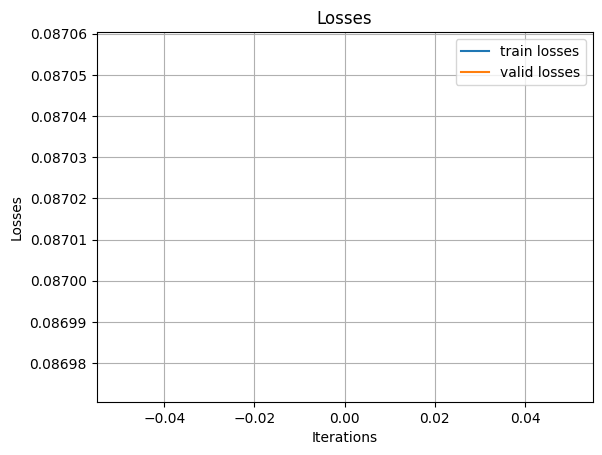

In [40]:
num_epochs = 1

## Contact Model
train_losses = []
valid_losses = []
tl_b = []

start = time.time()
for epoch in tqdm.tqdm(range(num_epochs)):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # --- TRAINING ---
    train_loss = 0
    contact_model.train()
    for i, samples in enumerate(dataloader_train):

        tactiles = samples['tactile'].float().to(device)
        contacts = samples['contact'].float().to(device)

        # forward pass
        output = contact_model(tactiles)

        # compute contact loss
        loss = contact_criterion(output, contacts)

        # backward pass
        contact_optimizer.zero_grad()
        loss.backward()
        contact_optimizer.step()

        # optimization
        train_loss += loss.item()
        tl_b.append(loss.item())

    train_losses.append(train_loss / datalen_train)

    # --- VALIDATION ---
    valid_loss = 0
    contact_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):

            tactiles = samples['tactile'].float().to(device)
            contacts = samples['contact'].float().to(device)

            # forward pass contact_model
            output = contact_model(tactiles)
            # compute contact loss
            loss = contact_criterion(output, contacts)

            valid_loss += loss.item()

    valid_losses.append(valid_loss / datalen_valid)

    # save contact_model with torch.save
    torch.save(contact_model.state_dict(), f"contact_model_epoch_{epoch+1}.pth")


elapse = time.time() - start
print('Time used (Sec): ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses, valid_losses)

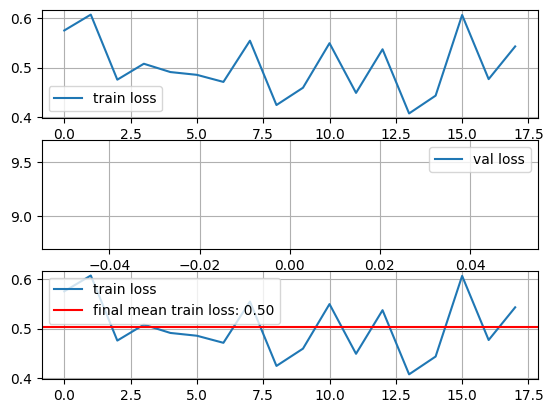

In [ ]:
plt.subplot(311)
plt.plot(tl_b, label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(valid_loss, label='val loss')
plt.grid(True)
plt.legend()

plt.subplot(313)
plt.plot(tl_b, label='train loss')
fml = np.mean(tl_b)
plt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))
plt.grid(True)
plt.legend()


Epoch [1/1]
> Time used (Sec):  243.36922597885132  per epoch used:  243.36922597885132


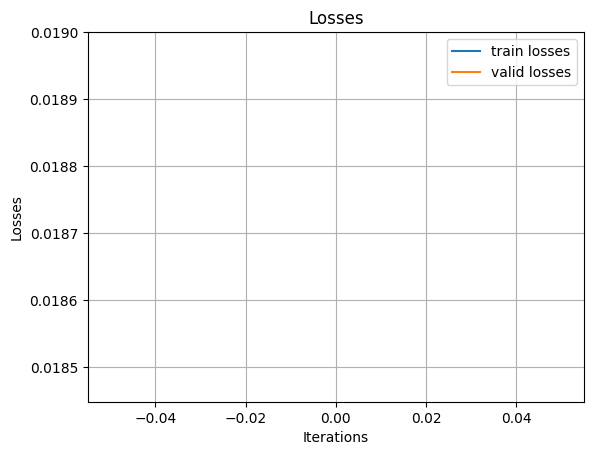

In [41]:
## Tactile Depth Model
train_losses_, valid_losses_ = [], []
tl_b_ = []
start = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print('>', end=' ')

    train_loss = 0
    tactile_depth_model.train()
    for i, samples in enumerate(dataloader_train):

        tactiles = samples['tactile'].float().to(device)
        depths = samples['depth'].float().to(device)

        # results from contact
        with torch.no_grad():
            contact_output = contact_model(tactiles)
        # forward pass
        depth_pred = tactile_depth_model(tactiles, contact_output)
        loss = tactile_depth_criterion(depth_pred, depths)
        # backward pass
        tactile_depth_optimizer.zero_grad()
        loss.backward()
        tactile_depth_optimizer.step()
        # optimization

        train_loss += loss.item()
        tl_b_.append(loss.item())

    train_losses_.append(train_loss / datalen_train)

    valid_loss = 0
    tactile_depth_model.eval()
    contact_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):

            tactiles = samples['tactile'].float().to(device)
            depths = samples['depth'].float().to(device)

            # results from tactile_depth network
            tactile_depth_model.eval()
            with torch.no_grad():
                contact_output = contact_model(tactiles)
            # forward pass tactile_depth_model
            depth_pred = tactile_depth_model(tactiles, contact_output)
            # compute loss from tactile_depth_criterion
            loss = tactile_depth_criterion(depth_pred, depths)

            valid_loss += loss.item()
    valid_losses_.append(valid_loss / datalen_valid)

    # save save tactile_depth_model with torch.save
    torch.save(tactile_depth_model.state_dict(), f"tactile_depth_model_epoch_{epoch+1}.pth")

elapse = time.time() - start
print('Time used (Sec): ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses_, valid_losses_)

## Step 5: Evaluation *(10 points)*

In [ ]:
def depth_metrics(pred, gt, eps=1e-6):
    """Compute common depth estimation metrics."""
    pred = pred.clamp(min=eps)
    gt = gt.clamp(min=eps)
    error = torch.abs(gt - pred)

    abs_rel = torch.mean(error / gt)
    sq_rel  = torch.mean((error ** 2) / gt)
    rmse    = torch.sqrt(torch.mean((error) ** 2))
    rmse_log = torch.sqrt(torch.mean((torch.log(gt) - torch.log(pred)) ** 2))

    ratio = torch.max(gt / pred, pred / gt)
    delta1 = torch.mean((ratio < 1.25).float())
    delta2 = torch.mean((ratio < 1.25 ** 2).float())
    delta3 = torch.mean((ratio < 1.25 ** 3).float())

    return {
        'Abs Relative difference': abs_rel.item(),
        'Squared Relative difference': sq_rel.item(),
        'RMSE (Linear)': rmse.item(),
        'RMSE (log)': rmse_log.item(),
        'threshold δ < 1.25': delta1.item(),
        'threshold δ < 1.25^2': delta2.item(),
        'threshold δ < 1.25^3': delta3.item()
    }

In [ ]:
## Evaluation
## You should evaluate multiple error and accuracy metrics that are used for depth estimation. Some of them are mentioned in Section 4.3 in https://arxiv.org/pdf/1406.2283.pdf
## Provide per-object metric results and discuss how object shape influences the performance of your method.
#outputs = np.array([])
metrics_list = []
fig, axes = plt.subplots(10, 3, figsize=(9, 25))
#fig.suptitle("Tactile Image | Predicted Depth | Predicted Contact", fontsize=14)

for i, samples in enumerate(dataloader_valid):
    if i >= 10:
        break
    tactiles = samples['tactile'].float().to(device)
    depths = samples['depth'].float().to(device)

    # results from contact network
    contact_model.eval()
    with torch.no_grad():
        contact_output = contact_model(tactiles)
        #contact_output = contact_model(tactiles).unsqueeze(1)
        #contact_output = torch.sigmoid(contact_output) #do we need this?

    # results from tactile depth network
    tactile_depth_model.eval()
    with torch.no_grad():
        tactile_depth_output = tactile_depth_model(tactiles, contact_output)

     # Compute metrics on depth
    m = depth_metrics(tactile_depth_output, depths)
    metrics_list.append(m)

    #code below for plotting
    img = tactiles[0].permute(1, 2, 0).cpu()
    depth_vis = tactile_depth_output[0, 0].cpu()
    contact_vis = contact_output[0, 0].cpu()

    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title("Tactile Input")
    axes[i, 1].imshow(depth_vis, cmap='inferno')
    axes[i, 1].set_title("Predicted Depth")
    axes[i, 2].imshow(contact_vis, cmap='gray')
    axes[i, 2].set_title("Predicted Contact")

# show 10 sample images (from both the train and test sets) in a subplot figure.
#  Each row should represent a tactile image, and there should be three columns: 
# the original image, the predicted depth, and the predicted contact.
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

metrics_avg = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
print("Validation Metrics:")
for k, v in metrics_avg.items():
    print(f"{k:8s}: {v:.4f}")

Define a function below that instantializes the networks again and loads the weights for new predictions. This function will be used for testing purposes.

In [ ]:
def predict(tactile_image):
  # Re-instantiate models
  contact_model = ContactNet(init=True).to(device)
  tactile_depth_model = TactileDepthNet(init=True).to(device)
  contact_model.eval()
  tactile_depth_model.eval()

  with torch.no_grad():
      tactile_image = tactile_image.unsqueeze(0).to(device)  # add batch dim
      coarse = contact_model(tactile_image)
      depth  = tactile_depth_model(tactile_image, coarse)
      contact = torch.sigmoid(coarse)  # convert logits to probabil

  return contact, depth

# for testing 
samples = next(iter(dataloader_valid))
tactile_image = samples['tactile'][0]  # first image in batch
predict(tactile_image)

**Grading Criteria:**




Step 1: Data-loading => 10%

Step 2: Network Design => 40%

Step 3: Loss Function => 10%

Step 4: Training Networks ==> 30%

Step 5: Evaluations ==> 10%


Refrences:

[1] [Depth Map Prediction from a Single Image
using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf)

[2] [MidasTouch: Monte-Carlo inference over
distributions across sliding touch](https://arxiv.org/pdf/2210.14210.pdf)

[3] [depth-eigen](https://github.com/shuuchen/depth_eigen/tree/master)
